In [1]:
!pip install pillow

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import gym
from gym.utils import play 

pygame 2.1.2 (SDL 2.0.18, Python 3.9.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:

from rl.core import Processor
from rl.memory import SequentialMemory

In [5]:
!pip install gym[atari]

In [ ]:
env = gym.make('Breakout-v0')
env.reset()

In [10]:
play.play(env, zoom=3)

In [9]:
env.close()

In [11]:
WIN_LENGTH = 3

In [12]:
from collections import deque

In [16]:
np.random.seed(42)
env.reset()

sequential_frame_buffer = []
temp_sequential_frames = deque(maxlen=WIN_LENGTH)
for i in range(10):
    if i == 1:
        action = 1
    else:
        action = 3
    observation, reward, done, info = env.step(action)

    if(len(temp_sequential_frames) == WIN_LENGTH):
        sequential_frame_buffer.append(list(temp_sequential_frames))

    temp_sequential_frames.append(observation)


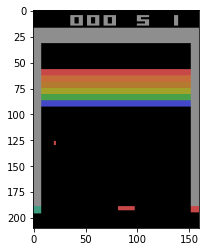

In [36]:
%matplotlib inline
plt.imshow(sequential_frame_buffer[2][0])

In [37]:
memory = SequentialMemory(limit=1000, window_length=WIN_LENGTH)

In [40]:
IMG_SHAPE = (84, 84)

In [38]:
from rl.core import Processor
class BreakOutProcessor(Processor):
    def process_observation(self, observation):
        img = Image.fromarray(observation)
        img = img.resize(IMG_SHAPE)
        img = img.convert('L')
        return np.array(img)

In [41]:
sample_images = []
breakout_proc = BreakOutProcessor()
env.reset()

for i in range(200):
    action =  env.action_space.sample()
    observation, reward, done, info = env.step(action)
    sample_images.append(breakout_proc.process_observation(observation))
env.close()

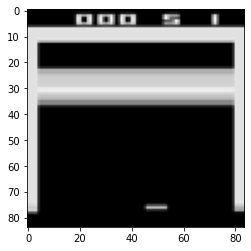

In [44]:
plt.imshow(sample_images[5], cmap='gray')

In [45]:
import tensorflow as tf

In [46]:
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

In [47]:
env = gym.make('Breakout-v4')
nb_actions = env.action_space.n

In [48]:
IMG_SHAPE = (84, 84)
WINDOW_LENGTH = 4

In [51]:
class ImageProcessor(Processor):
    def process_observation(self, observation):
        img = Image.fromarray(observation)
        img = img.resize(IMG_SHAPE)
        img = img.convert('L')
        return img.astype('uint8')

    def process_state_batch(self, batch):
        processed_batch = batch.astype('float32') / 255.
        return processed_batch
    
    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

In [52]:
input_shape = (WINDOW_LENGTH,) + IMG_SHAPE

In [53]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Permute((2, 3, 1), input_shape=input_shape),
    tf.keras.layers.Conv2D(32, (8, 8), strides=(4, 4), activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Conv2D(64, (4, 4), strides=(2, 2), activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_normal'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(nb_actions, activation='linear')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute (Permute)           (None, 84, 84, 4)         0         
                                                                 
 conv2d (Conv2D)             (None, 20, 20, 32)        8224      
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 512)               1606144   
                                                                 
 dense_1 (Dense)             (None, 4)                 2

In [56]:
memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)
processor = ImageProcessor()
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05, nb_steps=1000000)
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=50000, target_model_update=10000, policy=policy, processor=processor, gamma=.99, train_interval=4, delta_clip=1.)
dqn.compile(tf.keras.optimizers.Adam(lr=.00025), metrics=['mae'])

In [57]:
weights_filename = 'dqn_breakout_weights.h5f'
checkpoint_weights_filename = 'dqn_breakout_weights_checkpoint.h5f'

checkpoint_callback = ModelIntervalCheckpoint(checkpoint_weights_filename, interval=100000)

In [ ]:
dqn.fit(env, nb_steps=100000, visualize=False, verbose=1, callbacks=[checkpoint_callback])

In [ ]:
dqn.test(env, nb_episodes=5, visualize=True)